# CNN + LSTM 

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Simulating the dataframe with a growing circle contour and noise
def create_circle_contour_data(num_samples, time_steps, x_dim, y_dim):
    data = []
    labels = []
    for _ in range(num_samples):
        sequence = []
        center_x, center_y = x_dim // 2, y_dim // 2
        max_radius = min(x_dim, y_dim) // 2
        growth_rate = max_radius / time_steps

        for t in range(time_steps):
            radius = int(growth_rate * t)
            grid = np.zeros((x_dim, y_dim))
            y, x = np.ogrid[:x_dim, :y_dim]
            mask_inner = (x - center_x)**2 + (y - center_y)**2 <= radius**2
            mask_outer = (x - center_x)**2 + (y - center_y)**2 <= (radius - 1)**2
            grid[mask_inner & ~mask_outer] = 1
            noise = np.random.normal(0, 0.1, (x_dim, y_dim))
            noisy_grid = np.clip(grid + noise, 0, 1)
            sequence.append(noisy_grid)

        data.append(sequence[:-1])  # Inputs: time steps except the last
        labels.append(sequence[1:])  # Labels: shifted time steps

    return np.array(data), np.array(labels)

# Parameters
num_samples = 1000
time_steps = 10
x_dim, y_dim = 32, 32

# Generate dataset
data, labels = create_circle_contour_data(num_samples, time_steps, x_dim, y_dim)

# Split into train and test
train_size = int(num_samples * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Custom Dataset class
class ShapeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(4)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = ShapeDataset(train_data, train_labels)
test_dataset = ShapeDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Neural Network
class CNNLSTMModel(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(CNNLSTMModel, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(16 * x_dim * y_dim, 128, batch_first=True)
        self.fc = nn.Linear(128, x_dim * y_dim)

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.size()
        x = x.view(batch_size * time_steps, channels, height, width)
        x = torch.relu(self.conv(x))
        x = self.flatten(x)
        x = x.view(batch_size, time_steps, -1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = x.view(batch_size, time_steps, height, width)
        return x

# Initialize model, loss, and optimizer
model = CNNLSTMModel(x_dim, y_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Permute dimensions to match PyTorch input format
            inputs = inputs.permute(0, 1, 4, 2, 3).contiguous()  # (batch, time_steps, channels, height, width)
            targets = targets.permute(0, 1, 2, 3).contiguous()  # (batch, time_steps, height, width)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Permute dimensions to match PyTorch input format
            inputs = inputs.permute(0, 1, 4, 2, 3).contiguous()
            targets = targets.permute(0, 1, 2, 3).contiguous()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss/len(test_loader):.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 0.0444
Epoch 2/10, Loss: 0.0353
Epoch 3/10, Loss: 0.0317
Epoch 4/10, Loss: 0.0280
Epoch 5/10, Loss: 0.0246
Epoch 6/10, Loss: 0.0217
Epoch 7/10, Loss: 0.0188
Epoch 8/10, Loss: 0.0145
Epoch 9/10, Loss: 0.0108
Epoch 10/10, Loss: 0.0084


In [2]:
# Evaluate the model
evaluate_model(model, test_loader, criterion)

Test Loss: 0.0075


In [12]:
# Function to plot inputs, predictions, and compare with targets
def plot_predictions(model, data, labels, num_samples=5, time_steps=10):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[:num_samples], dtype=torch.float32).unsqueeze(4).permute(0, 1, 4, 2, 3).contiguous()
        targets = labels[:num_samples]
        predictions = model(inputs).numpy()

    fig, axes = plt.subplots(num_samples, time_steps - 1, figsize=(15, num_samples * 6))
    for i in range(num_samples):
        for t in range(time_steps - 1):
            ax = axes[i, t] if num_samples > 1 else axes[t]
            ax.imshow(data[i, t], cmap='gray', alpha=0.5, label='Input')
            ax.imshow(predictions[i, t], cmap='jet', alpha=0.8, label='Prediction')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Step {t + 1} Pred")

    plt.tight_layout()
    plt.show()

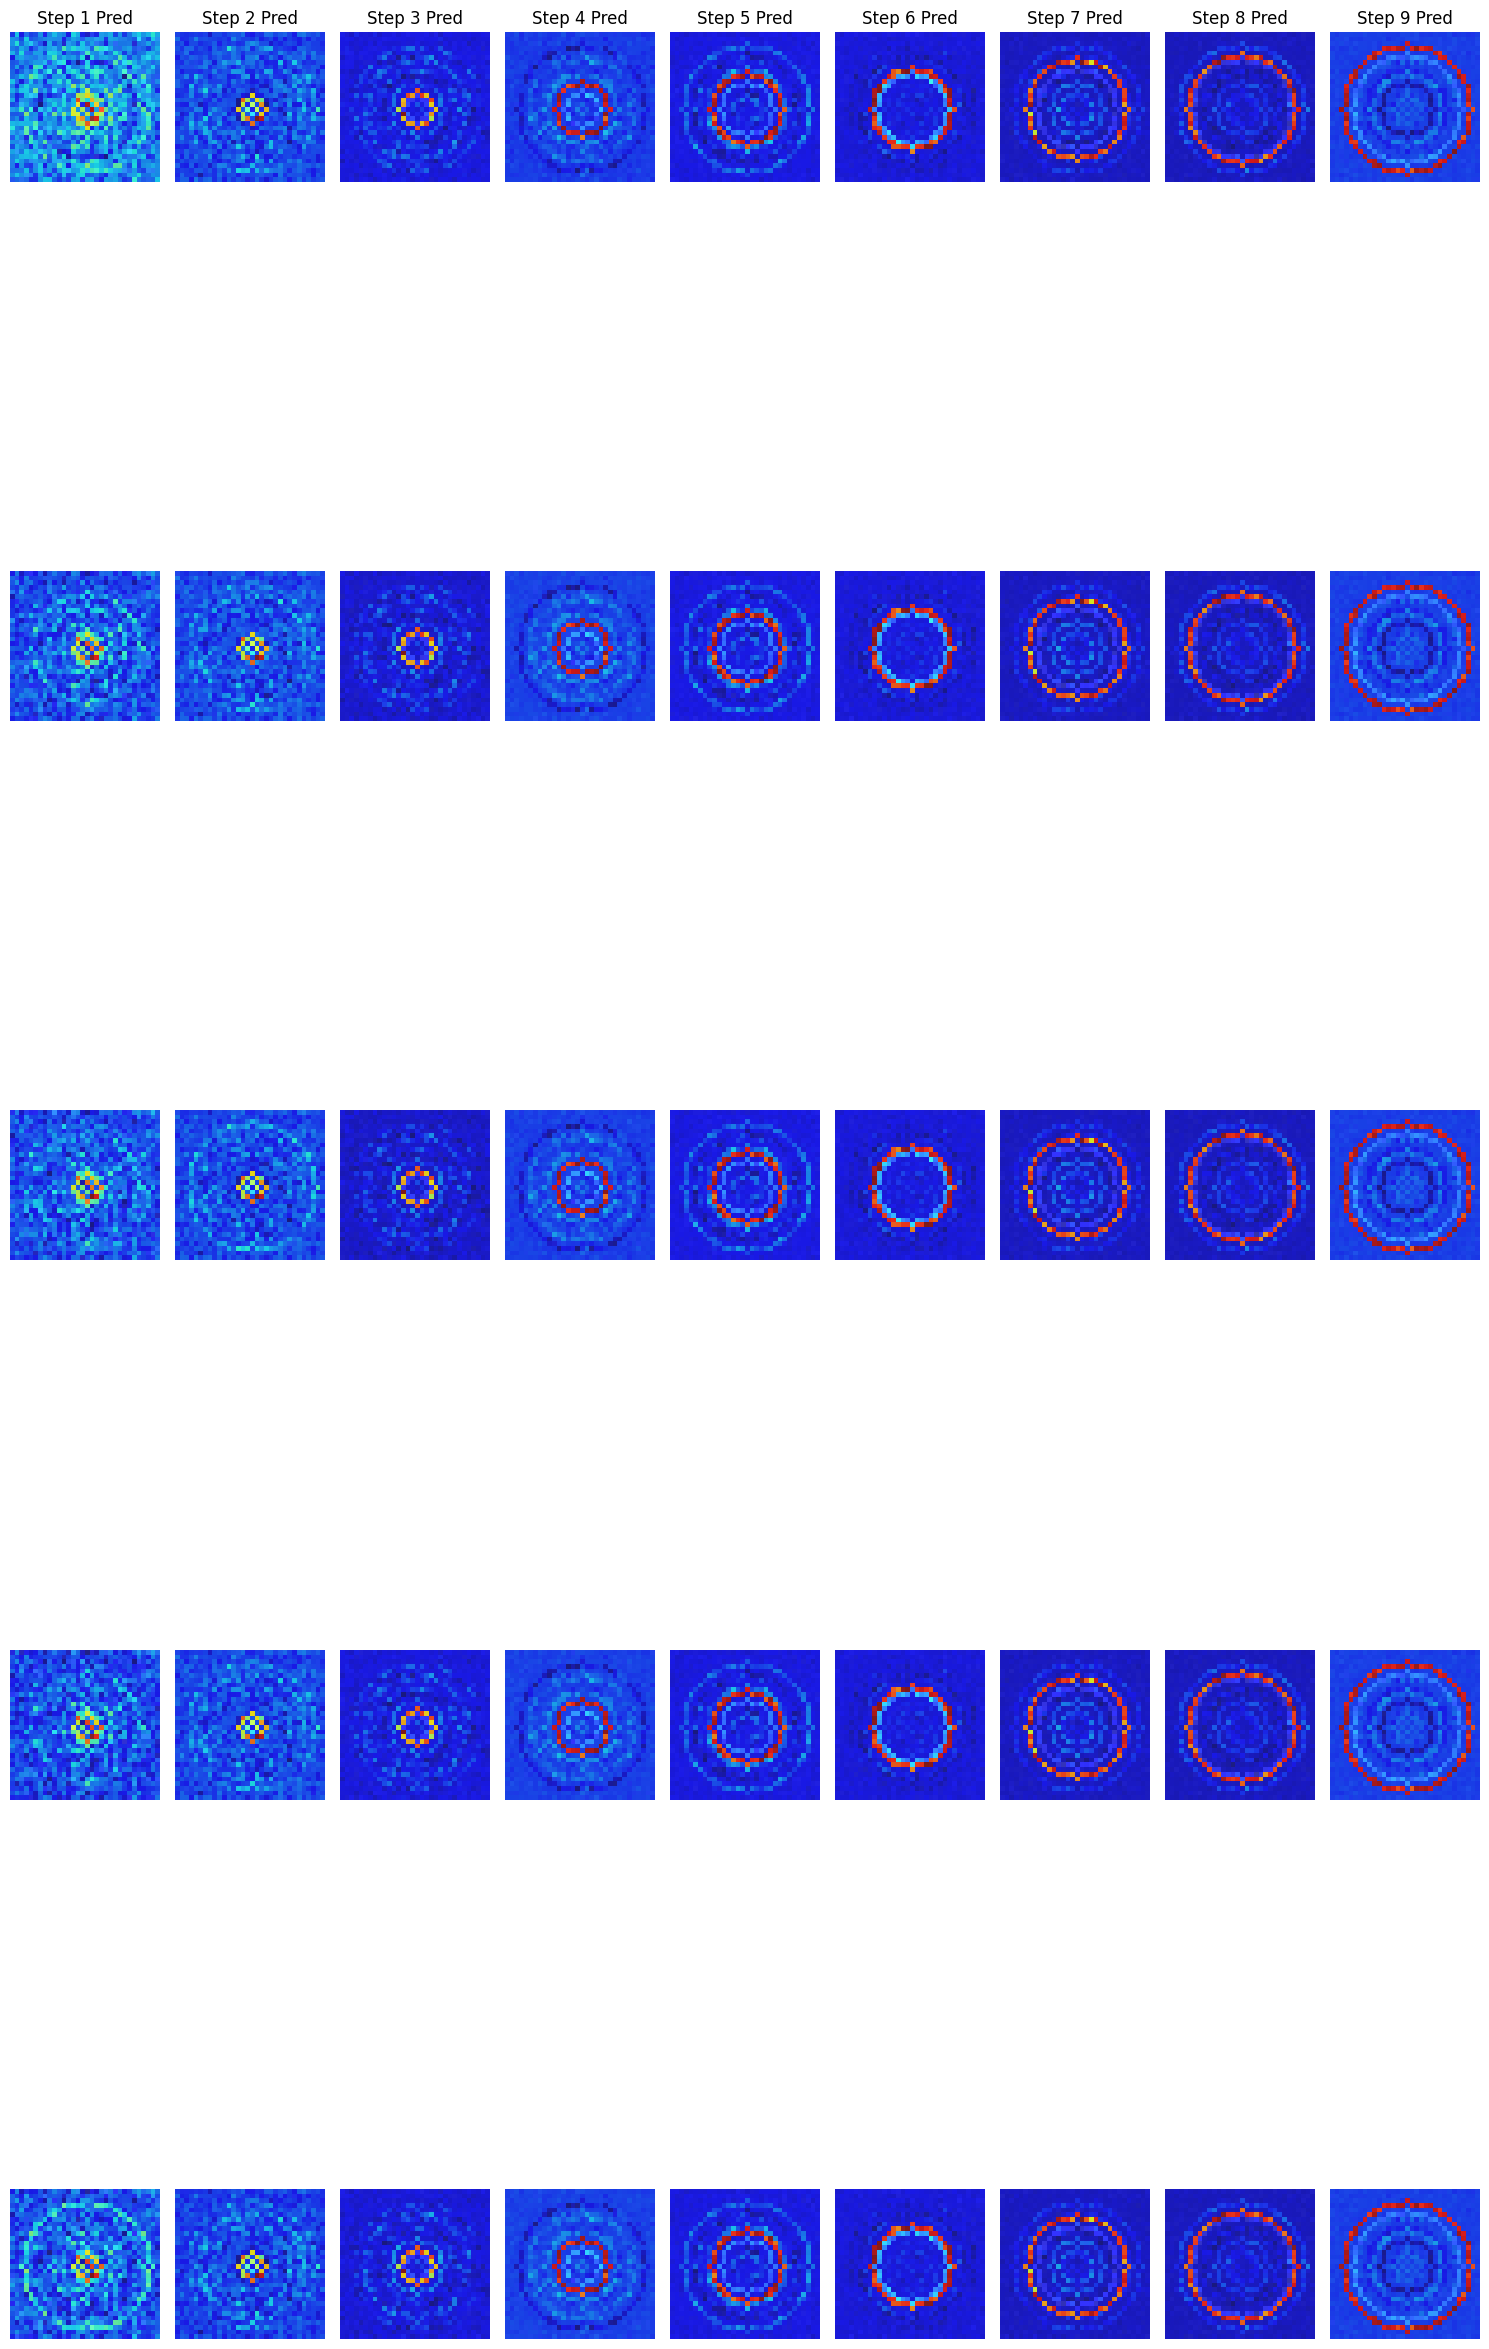

In [13]:
# Plot predictions
plot_predictions(model, test_data, test_labels, num_samples=5, time_steps=time_steps)

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Adapting the dataset for CO2 saturation data (3D predictions for CO2 plume)
def create_co2_data(dataset):
    # Assuming dataset is already a NumPy array with shape (81, 58, 20, 20)
    width, length, depth, time_steps = dataset.shape
    data = []
    labels = []

    for t in range(time_steps - 1):
        data.append(dataset[:, :, :, t])  # Inputs: time steps except the last
        labels.append(dataset[:, :, :, t + 1])  # Labels: shifted time steps

    data = np.array(data).transpose(3, 0, 1, 2)  # Reorder dimensions for PyTorch (batch, depth, width, length)
    labels = np.array(labels).transpose(3, 0, 1, 2)
    return data, labels

# Example shape parameters for CO2 data
dataset_shape = (81, 58, 20, 20)
np.random.seed(42)
dataset = np.random.rand(*dataset_shape)  # Replace this with actual CO2 saturation dataset

# Generate data and labels
data, labels = create_co2_data(dataset)

# Custom Dataset class
class CO2Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Split into train and test
num_samples = data.shape[0]
train_size = int(num_samples * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

train_dataset = CO2Dataset(train_data, train_labels)
test_dataset = CO2Dataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Neural Network
class CNNLSTM3DModel(nn.Module):
    def __init__(self, width, length, depth):
        super(CNNLSTM3DModel, self).__init__()
        self.conv3d = nn.Conv3d(1, 16, kernel_size=3, padding=1)  # 3D Convolution
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(16 * width * length * depth, 128, batch_first=True)
        self.fc = nn.Linear(128, width * length * depth)

    def forward(self, x):
        batch_size, channels, depth, height, width = x.size()
        x = torch.relu(self.conv3d(x))
        x = self.flatten(x)
        x = x.view(batch_size, depth, -1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = x.view(batch_size, depth, height, width)
        return x

# Initialize model, loss, and optimizer
model = CNNLSTM3DModel(81, 58, 20)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.permute(0, 1, 2, 3, 4).contiguous()  # Ensure dimensions are correct
            targets = targets.permute(0, 1, 2, 3).contiguous()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.permute(0, 1, 2, 3, 4).contiguous()
            targets = targets.permute(0, 1, 2, 3).contiguous()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss/len(test_loader):.4f}")

# Function to plot predictions
def plot_3d_predictions(model, data, labels, num_samples=5):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[:num_samples], dtype=torch.float32).unsqueeze(1).contiguous()
        targets = labels[:num_samples]
        predictions = model(inputs).numpy()

    for i in range(num_samples):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(data[i, 0, :, :, 0], cmap='gray')
        axes[0].set_title("Input")
        axes[1].imshow(predictions[i, 0, :, :, 0], cmap='jet')
        axes[1].set_title("Prediction")
        axes[2].imshow(targets[i, 0, :, :, 0], cmap='gray')
        axes[2].set_title("Target")
        plt.show()

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

RuntimeError: shape '[16, 19, 81, 58]' is invalid for input of size 28563840

In [15]:
# Evaluate the model
evaluate_model(model, test_loader, criterion)

RuntimeError: shape '[4, 19, 81, 58]' is invalid for input of size 7140960

In [ ]:

# Plot predictions
plot_3d_predictions(model, test_data, test_labels, num_samples=5)
